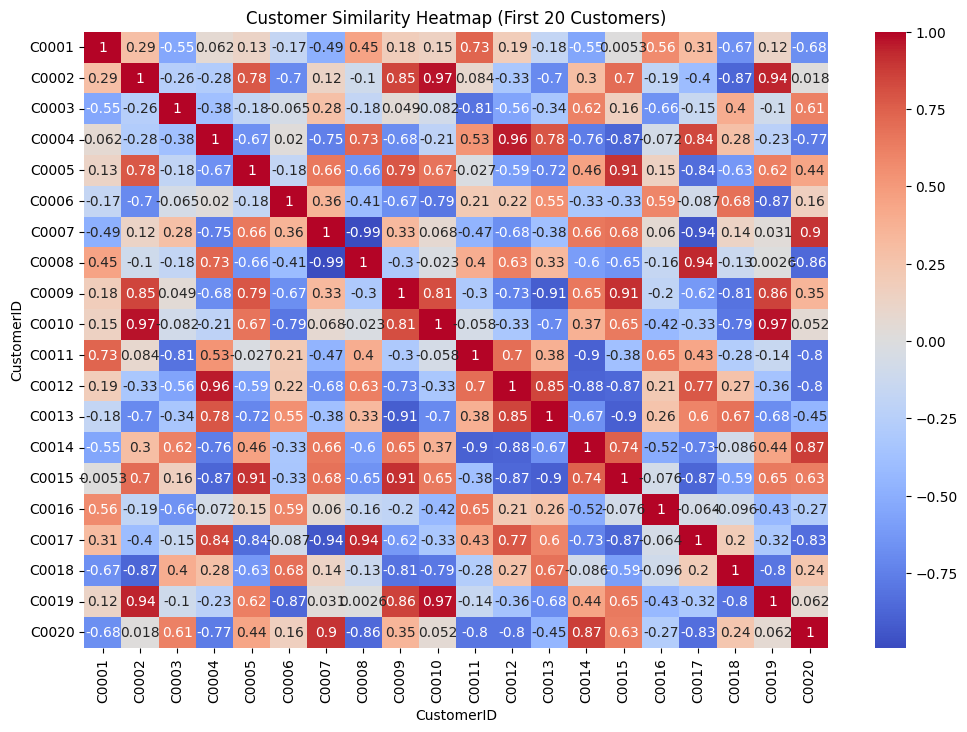

Lookalike model completed and saved to 'Prabhat_Kumar_Lookalike.csv'.


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Load datasets
customers_url = "https://drive.google.com/uc?id=1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE"
products_url = "https://drive.google.com/uc?id=1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0"
transactions_url = "https://drive.google.com/uc?id=1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF"

customers_df = pd.read_csv(customers_url)
products_df = pd.read_csv(products_url)
transactions_df = pd.read_csv(transactions_url)

# Merge transactions with product details to get product category info
transactions_df = transactions_df.merge(products_df, on='ProductID', how='left')

# Feature Engineering for Customer Profiles based on Transactions
customer_transactions = transactions_df.groupby('CustomerID').agg(
    TotalSpent=('TotalValue', 'sum'),
    AvgSpent=('TotalValue', 'mean'),
    TotalQuantity=('Quantity', 'sum'),
    CategoriesPurchased=('Category', lambda x: x.nunique()),
    Recency=('TransactionDate', lambda x: (pd.to_datetime('today') - pd.to_datetime(x.max())).days)
).reset_index()

# Merge customer transactional features with demographic info
customer_profiles = pd.merge(customers_df, customer_transactions, on='CustomerID', how='left').fillna(0)

# Standardize Features
features_to_normalize = ['TotalSpent', 'AvgSpent', 'TotalQuantity', 'CategoriesPurchased', 'Recency']
scaler = StandardScaler()
customer_profiles[features_to_normalize] = scaler.fit_transform(customer_profiles[features_to_normalize])

# Perform PCA for dimensionality reduction (Optional but helps with speed & better clustering)
pca = PCA(n_components=2)
customer_profiles['PCA1'], customer_profiles['PCA2'] = zip(*pca.fit_transform(customer_profiles[features_to_normalize]))

# Clustering for optimized lookalike search
kmeans = KMeans(n_clusters=5, random_state=42)
customer_profiles['Cluster'] = kmeans.fit_predict(customer_profiles[features_to_normalize])

# Cosine Similarity for Lookalike Model
similarity_matrix = cosine_similarity(customer_profiles[features_to_normalize])

# Generate Lookalikes for the first 20 customers
lookalike_map = {}
customer_ids = customer_profiles['CustomerID'].values
for i in range(20):  # First 20 customers
    customer_id = customer_ids[i]
    similarities = list(enumerate(similarity_matrix[i]))
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[1:4]  # Exclude self, top 3 similar
    lookalike_map[customer_id] = [(customer_ids[j], round(score, 4)) for j, score in similarities]

# Create the Lookalike DataFrame
lookalike_df = pd.DataFrame({
    'CustomerID': list(lookalike_map.keys()),
    'Lookalikes': [str(v) for v in lookalike_map.values()]
})

# Save to CSV
lookalike_df.to_csv('Prabhat_Kumar_Lookalike.csv', index=False)

# Visualization: Heatmap for similarity matrix (First 20 customers)
similarity_df = pd.DataFrame(similarity_matrix, index=customer_profiles['CustomerID'], columns=customer_profiles['CustomerID'])
plt.figure(figsize=(12, 8))
sns.heatmap(similarity_df.iloc[:20, :20], annot=True, cmap="coolwarm")
plt.title("Customer Similarity Heatmap (First 20 Customers)")
plt.xlabel("CustomerID")
plt.ylabel("CustomerID")
plt.show()

print("Lookalike model completed and saved to 'Prabhat_Kumar_Lookalike.csv'.")
